### Dataset Split

In [1]:
import pandas as pd


In [2]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')




### Image Preprocessing

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import easyocr

In [4]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\jatin\anaconda3\envs\easy\lib\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray,(500,500))
    return resized_img

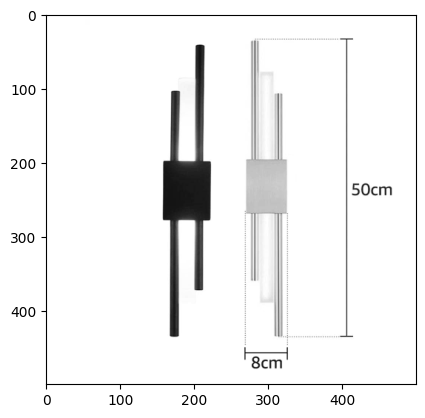

In [20]:
path = r'D:\amazon\Optical-Character-Recognition\images\41ygXRvf8lL.jpg'
imaged= preprocess_image(path)
plt.imshow(imaged,cmap='gray')
plt.show()

In [21]:
result = reader.readtext(imaged)
print(result)

[([[410, 224], [470, 224], [470, 250], [410, 250]], 'S0cm', 0.30929964780807495), ([[274, 458], [322, 458], [322, 484], [274, 484]], '8cm', 0.9998073598684561)]


### Extracting Text from images

In [22]:
def extract_text(image_path):
    preprocessed_img = preprocess_image(image_path)
    result = reader.readtext(preprocessed_img)

    extracted_text = " ".join([text[1] for text in result])
    return extracted_text


In [23]:
text = extract_text(path)
print(f"Extracted Text : {text}")

Extracted Text : S0cm 8cm


### Mapping extracted text to entity values

In [24]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

allowed_units = {unit for entity in entity_unit_map for unit in entity_unit_map[entity]}


In [38]:
import re

def extract_entity(extracted_text,allowed):
    pattern = r'(\d+\.?\d*)\s*(' + '|'.join(allowed) + r')'
    match = re.search(pattern,extracted_text.lower())

    if match:
        value,unit = match.groups()
        return f"{value} {unit}"
    
    return ""

In [39]:
txt = extract_text(path)
entity_value = extract_entity(txt,allowed_units)
print(entity_value)

### Prediction

In [41]:
predictions = []
image_dir = '../images/'

for index,row in test_df.iterrows():
    image_file= row['image_link'].split('/')[-1]
    image_path = os.path.join(image_dir,image_file)

    if os.path.exists(image_path):
        extracted = extract_text(image_path)
        predicted = extract_entity(extracted, allowed_units)
    else:
        predicted = ""


predictions.append({
    'index': row['index'],
    'prediction':predicted
})

output_df = pd.DataFrame(predictions)
output_df.to_csv('../output/test_out.csv',index =False)